In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.colors as mcolors


In [2]:
DATASET_NAME = "dataset"
MODEL_NAME = 'VanillaCNN'
DATASET_VAR = 'base_final'
MODEL_PATH = f'./models/{MODEL_NAME}'

In [3]:
results_orig = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/results/results_borig.npz', allow_pickle=True)
results_base = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/results/results_bbase_final.npz', allow_pickle=True)
results_baugm = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/results/results_baugm_final.npz', allow_pickle=True)
results_cnn = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/VanillaCNN/base_final/results.npz', allow_pickle=True)
results_augm = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/VanillaCNN/augm_final/results.npz', allow_pickle=True)

class_names = results_augm['class_names']

In [4]:
models_results = {
    'orig': {
        'y_true': results_orig['y_true'],
        'y_pred': results_orig['y_pred'], 
        'y_pred_proba': results_orig['y_pred_proba'],
        'class_names': results_orig['class_names'],
        'alias': "Original BirdNET"
    },
    'base': {
        'y_true': results_base['y_true'],
        'y_pred': results_base['y_pred'],
        'y_pred_proba': results_base['y_pred_proba'],
        'class_names': results_base['class_names'],
        'alias': "Fine-tuned BirdNET"
    },
    'augm': {
        'y_true': results_baugm['y_true'],
        'y_pred': results_baugm['y_pred'],
        'y_pred_proba': results_baugm['y_pred_proba'],
        'class_names': results_baugm['class_names'],
        'alias': "Fine-tuned BirdNET + Data augmentation"
    },
    'base_cnn': {
        'y_true': results_cnn['y_true'],
        'y_pred': results_cnn['y_pred'],
        'y_pred_proba': results_cnn['y_pred_proba'],
        'class_names': results_cnn['class_names'],
        'alias': "Vanilla CNN"
    },
    'augm_cnn': {
        'y_true': results_augm['y_true'],
        'y_pred': results_augm['y_pred'],
        'y_pred_proba': results_augm['y_pred_proba'],
        'class_names': results_augm['class_names'],
        'alias': "Vanilla CNN + Data augmentation"
    },
}


# Metrics table

In [5]:
import pandas as pd
from sklearn.metrics import classification_report

def generate_latex_table(avg_type):
    rows = []
    for model, metrics in models_results.items():
        alias = models_results[model]['alias']
        y_true = models_results[model]['y_true']
        y_pred = models_results[model]['y_pred']
        classes = models_results[model]['class_names']
        report = classification_report(y_true, y_pred, target_names=classes, zero_division=0, output_dict=True)
        precision = report[avg_type]['precision']
        recall = report[avg_type]['recall']
        f1 = report[avg_type]['f1-score']
        rows.append((alias, precision, recall, f1))
    df = pd.DataFrame(rows, columns=['Model', 'Precision', 'Recall', 'F1-score'])
    return df.to_latex(index=False, caption=f'Performance metrics between models - {avg_type.capitalize()} average',
                       label=f'tab:performance_metrics_{avg_type.replace(" ", "_")}', float_format="%.3f")


In [6]:
print(generate_latex_table('micro avg'))

\begin{table}
\caption{Performance metrics between models - Micro avg average}
\label{tab:performance_metrics_micro_avg}
\begin{tabular}{lrrr}
\toprule
Model & Precision & Recall & F1-score \\
\midrule
Original BirdNET & 0.806 & 0.185 & 0.301 \\
Fine-tuned BirdNET & 0.595 & 0.706 & 0.646 \\
Fine-tuned BirdNET + Data augmentation & 0.621 & 0.739 & 0.675 \\
Vanilla CNN & 0.433 & 0.324 & 0.371 \\
Vanilla CNN + Data augmentation & 0.499 & 0.504 & 0.502 \\
\bottomrule
\end{tabular}
\end{table}



In [7]:
print(generate_latex_table('weighted avg'))

\begin{table}
\caption{Performance metrics between models - Weighted avg average}
\label{tab:performance_metrics_weighted_avg}
\begin{tabular}{lrrr}
\toprule
Model & Precision & Recall & F1-score \\
\midrule
Original BirdNET & 0.429 & 0.185 & 0.245 \\
Fine-tuned BirdNET & 0.626 & 0.706 & 0.627 \\
Fine-tuned BirdNET + Data augmentation & 0.632 & 0.739 & 0.672 \\
Vanilla CNN & 0.591 & 0.324 & 0.392 \\
Vanilla CNN + Data augmentation & 0.600 & 0.504 & 0.527 \\
\bottomrule
\end{tabular}
\end{table}



In [8]:
print(generate_latex_table('samples avg'))

\begin{table}
\caption{Performance metrics between models - Samples avg average}
\label{tab:performance_metrics_samples_avg}
\begin{tabular}{lrrr}
\toprule
Model & Precision & Recall & F1-score \\
\midrule
Original BirdNET & 0.195 & 0.170 & 0.177 \\
Fine-tuned BirdNET & 0.668 & 0.725 & 0.679 \\
Fine-tuned BirdNET + Data augmentation & 0.681 & 0.688 & 0.673 \\
Vanilla CNN & 0.304 & 0.331 & 0.306 \\
Vanilla CNN + Data augmentation & 0.455 & 0.528 & 0.471 \\
\bottomrule
\end{tabular}
\end{table}



In [9]:
selected_model = models_results["base_cnn"]

# Classification report

In [11]:
from sklearn.metrics import classification_report
import pandas as pd
from io import StringIO

selected_model = models_results["base_cnn"]
clf_report = classification_report(selected_model['y_true'], selected_model['y_pred'], target_names=selected_model['class_names'], output_dict=True, zero_division=0)
clf_report_df = pd.read_json(StringIO(json.dumps(clf_report)))
clf_report_df.T

,precision,recall,f1-score,support
Aeroplane,0.000000,0.000000,0.000000,22.0
Anthus trivialis_Tree Pipit,0.771930,0.825000,0.797583,160.0
Certhia familiaris_Eurasian Treecreeper,0.350427,0.445652,0.392344,92.0
Coccothraustes coccothraustes_Hawfinch,0.000000,0.000000,0.000000,87.0
Erithacus rubecula_European Robin,0.257329,0.142086,0.183082,556.0
Fringilla coelebs_Common Chaffinch,0.392587,0.378832,0.385587,1370.0
Lophophanes cristatus_Crested Tit,0.000000,0.000000,0.000000,23.0
Loxia curvirostra_Common Crossbill,0.916667,0.305556,0.458333,36.0
Muscicapa striata_Spotted Flycatcher,0.000000,0.000000,0.000000,173.0
None,0.803150,0.326714,0.464481,4683.0


# ROC AUC Curve

/var/tmp/ipykernel_23600/4152190249.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(selected_classes))


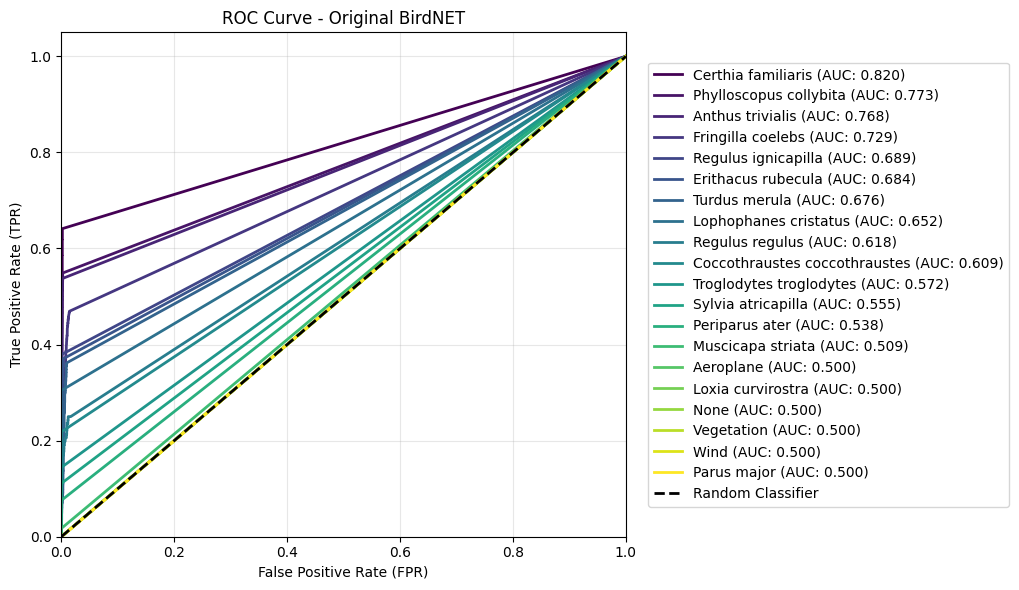

/var/tmp/ipykernel_23600/4152190249.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(selected_classes))


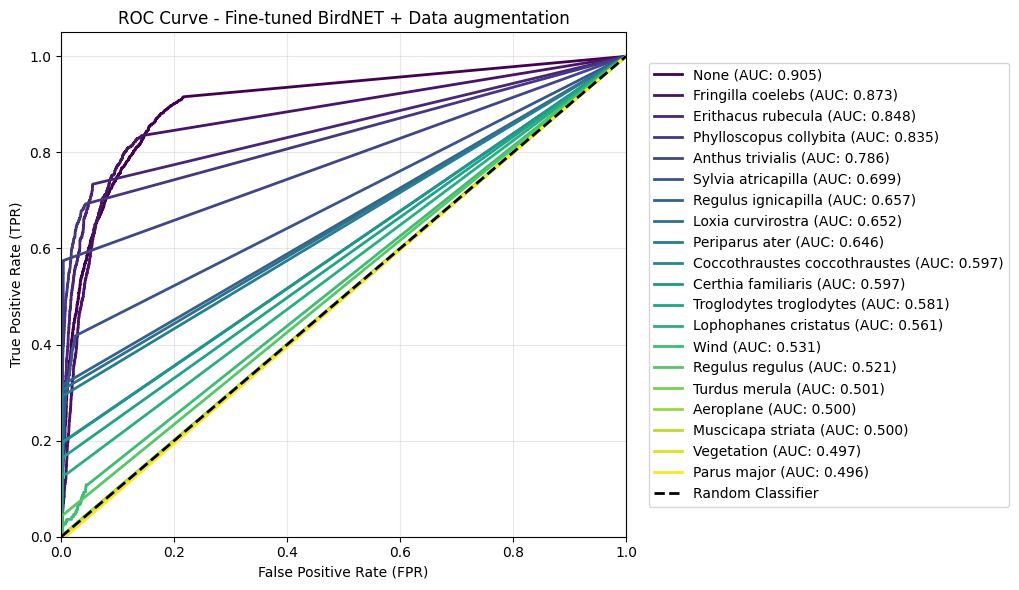

/var/tmp/ipykernel_23600/4152190249.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(selected_classes))


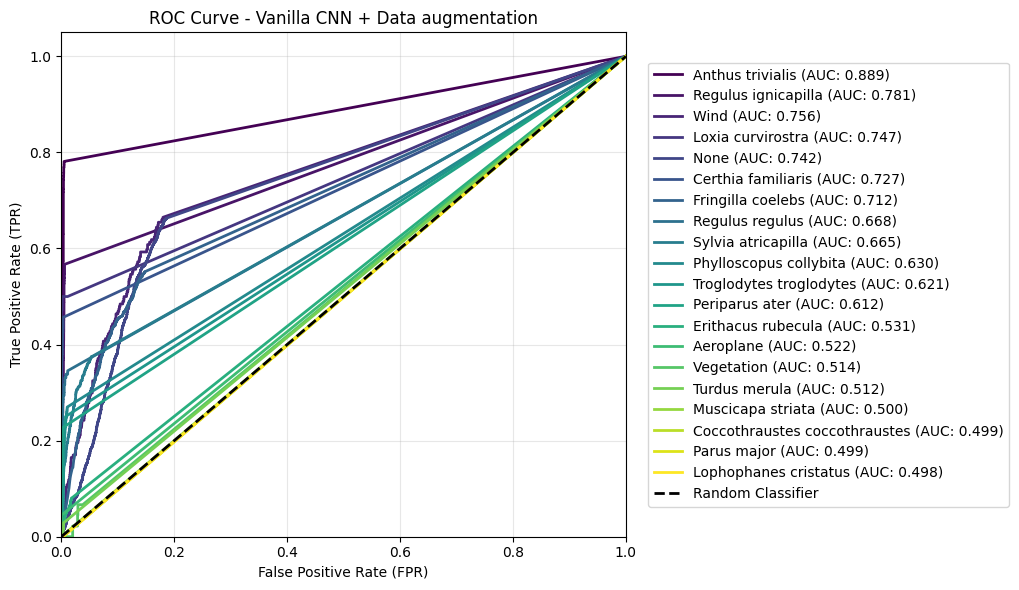

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm
import numpy as np

def plot_roc_curves(y_true, y_pred_proba, alias, class_names=None, selected_classes=None, top_n=10):
    """
    Disegna le curve ROC per ogni classe in un problema di classificazione multi-label,
    utilizzando una scala cromatica basata sui valori AUC.
    """
    n_classes = y_true.shape[1]

    if class_names is None:
        class_names = [f"classe {i}" for i in range(n_classes)]

    auc_scores = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append((i, roc_auc))

    # Ordina le classi in base all'AUC in ordine decrescente
    auc_scores.sort(key=lambda x: x[1], reverse=True)

    if selected_classes is None:
        selected_classes = [idx for idx, _ in auc_scores[:top_n]]

    # Mappa dei colori basata sull'ordine AUC
    cmap = cm.get_cmap('viridis', len(selected_classes))
    color_dict = {idx: cmap(i) for i, idx in enumerate(selected_classes)}

    plt.figure(figsize=(14, 6))

    for i in selected_classes:
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=color_dict[i],
                 label=f'{class_names[i].split("_")[0]} (AUC: {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {alias}')

    plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5), borderaxespad=0)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.grid(True, alpha=0.3)
    plt.show()

for model in ['orig', 'augm', 'augm_cnn']:
    plot_roc_curves(models_results[model]['y_true'], models_results[model]['y_pred_proba'], class_names=models_results[model]['class_names'], alias=models_results[model]['alias'], top_n=20)

# Confusion Matrix

In [12]:
from sklearn.metrics import multilabel_confusion_matrix

selected_model = models_results['augm']
mcm = multilabel_confusion_matrix(selected_model['y_true'], selected_model['y_pred'])

conf_matrices = []
for idx, label in enumerate(class_names):
    tn, fp, fn, tp = mcm[idx].ravel()
    conf_matrices.append({
        'Class': label.replace("_", " "),
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

conf_df = pd.DataFrame(conf_matrices)
conf_df

,Class,TP,FP,FN,TN
0,Aeroplane,0,0,22,8953
1,Anthus trivialis Tree Pipit,92,34,68,8781
2,Certhia familiaris Eurasian Treecreeper,18,19,74,8864
3,Coccothraustes coccothraustes Hawfinch,17,5,70,8883
4,Erithacus rubecula European Robin,408,467,148,7952
5,Fringilla coelebs Common Chaffinch,1144,1089,226,6516
6,Lophophanes cristatus Crested Tit,3,85,20,8867
7,Loxia curvirostra Common Crossbill,11,13,25,8926
8,Muscicapa striata Spotted Flycatcher,0,0,173,8802
9,None,4289,930,394,3362


In [13]:
latex_table = conf_df.to_latex(index=False, caption="Confusion matrix per species", label="tab:conf_matrix")
print(latex_table)

\begin{table}
\caption{Confusion matrix per species}
\label{tab:conf_matrix}
\begin{tabular}{lrrrr}
\toprule
Class & TP & FP & FN & TN \\
\midrule
Aeroplane & 0 & 0 & 22 & 8953 \\
Anthus trivialis Tree Pipit & 92 & 34 & 68 & 8781 \\
Certhia familiaris Eurasian Treecreeper & 18 & 19 & 74 & 8864 \\
Coccothraustes coccothraustes Hawfinch & 17 & 5 & 70 & 8883 \\
Erithacus rubecula European Robin & 408 & 467 & 148 & 7952 \\
Fringilla coelebs Common Chaffinch & 1144 & 1089 & 226 & 6516 \\
Lophophanes cristatus Crested Tit & 3 & 85 & 20 & 8867 \\
Loxia curvirostra Common Crossbill & 11 & 13 & 25 & 8926 \\
Muscicapa striata Spotted Flycatcher & 0 & 0 & 173 & 8802 \\
None & 4289 & 930 & 394 & 3362 \\
Parus major Great Tit & 0 & 67 & 14 & 8894 \\
Periparus ater Coal Tit & 62 & 14 & 150 & 8749 \\
Phylloscopus collybita Common Chiffchaff & 467 & 362 & 207 & 7939 \\
Regulus ignicapilla Common Firecrest & 182 & 24 & 393 & 8376 \\
Regulus regulus Goldcrest & 6 & 15 & 130 & 8824 \\
Sylvia atricapilla 

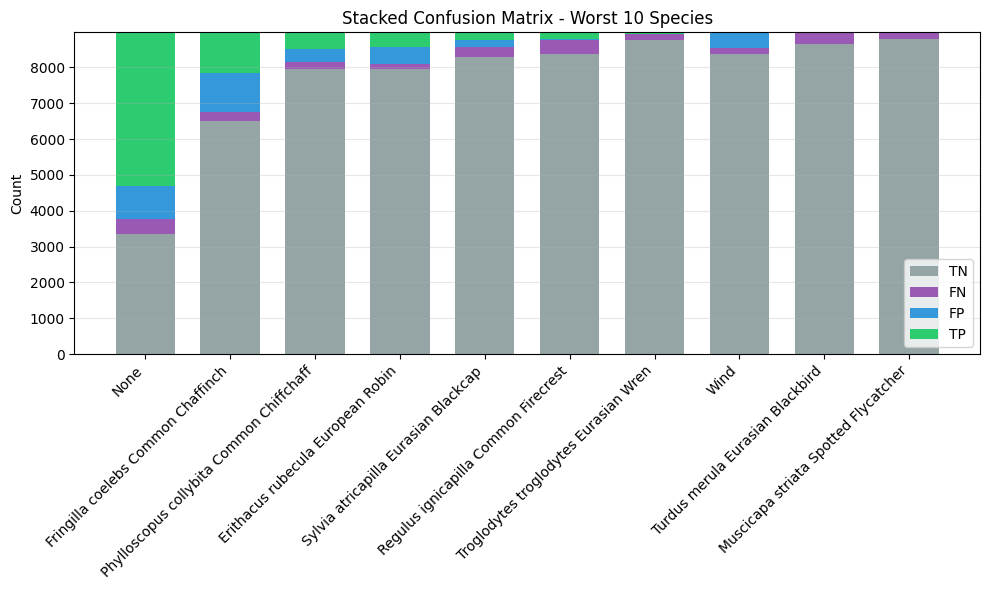

In [14]:
import matplotlib.pyplot as plt
import numpy as np

top_n = 20
conf_df['Errors'] = conf_df['FN'] + conf_df['FP']
worst_classes = conf_df.sort_values('Errors', ascending=False).head(10)

top_df = worst_classes.sort_values(by='TP', ascending=False).head(top_n)

labels = top_df['Class'].tolist()
tp = top_df['TP'].values
fp = top_df['FP'].values
fn = top_df['FN'].values
tn = top_df['TN'].values

x = np.arange(len(labels))
width = 0.7

fig, ax = plt.subplots(figsize=(10, 6))
colors = {
    'TP': '#2ecc71',  # verde
    'FP': '#3498db',  # Bright Blue
    'FN': '#9b59b6',  # Amethyst (Purple-ish)
    'TN': '#95a5a6'   # grigio
}

p1 = ax.bar(x, tn, width, label='TN', color=colors['TN'])
p2 = ax.bar(x, fn, width, bottom=tn, label='FN', color=colors['FN'])
p3 = ax.bar(x, fp, width, bottom=tn+fn, label='FP', color=colors['FP'])
p4 = ax.bar(x, tp, width, bottom=tn+fn+fp, label='TP', color=colors['TP'])

ax.set_ylabel('Count')
ax.set_title(f'Stacked Confusion Matrix - Worst 10 Species')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()
